-----------------------------------
System: pt-PE
GNN energy = -0.47 eV 
VASP energy = -207.79 eV
Prediction error = -207.32 eV
-----------------------------------
System: pt-PPit
GNN energy = -0.45 eV 
VASP energy = -257.18 eV
Prediction error = -256.73 eV
-----------------------------------
System: pt-PPst
GNN energy = -0.09 eV 
VASP energy = -257.48 eV
Prediction error = -257.38 eV
-----------------------------------
System: pt-PS
GNN energy = -1.86 eV 
VASP energy = -214.55 eV
Prediction error = -212.69 eV
-----------------------------------
System: pt-PET
GNN energy = -1.52 eV 
VASP energy = -337.67 eV
Prediction error = -336.16 eV
-----------------------------------
System: ru-PE
GNN energy = -0.10 eV 
VASP energy = -206.80 eV
Prediction error = -206.70 eV
-----------------------------------
System: ru-PPit
GNN energy = -0.35 eV 
VASP energy = -256.23 eV
Prediction error = -255.88 eV
-----------------------------------
System: ru-PPst
GNN energy = -0.09 eV 
VASP energy = -256.53 

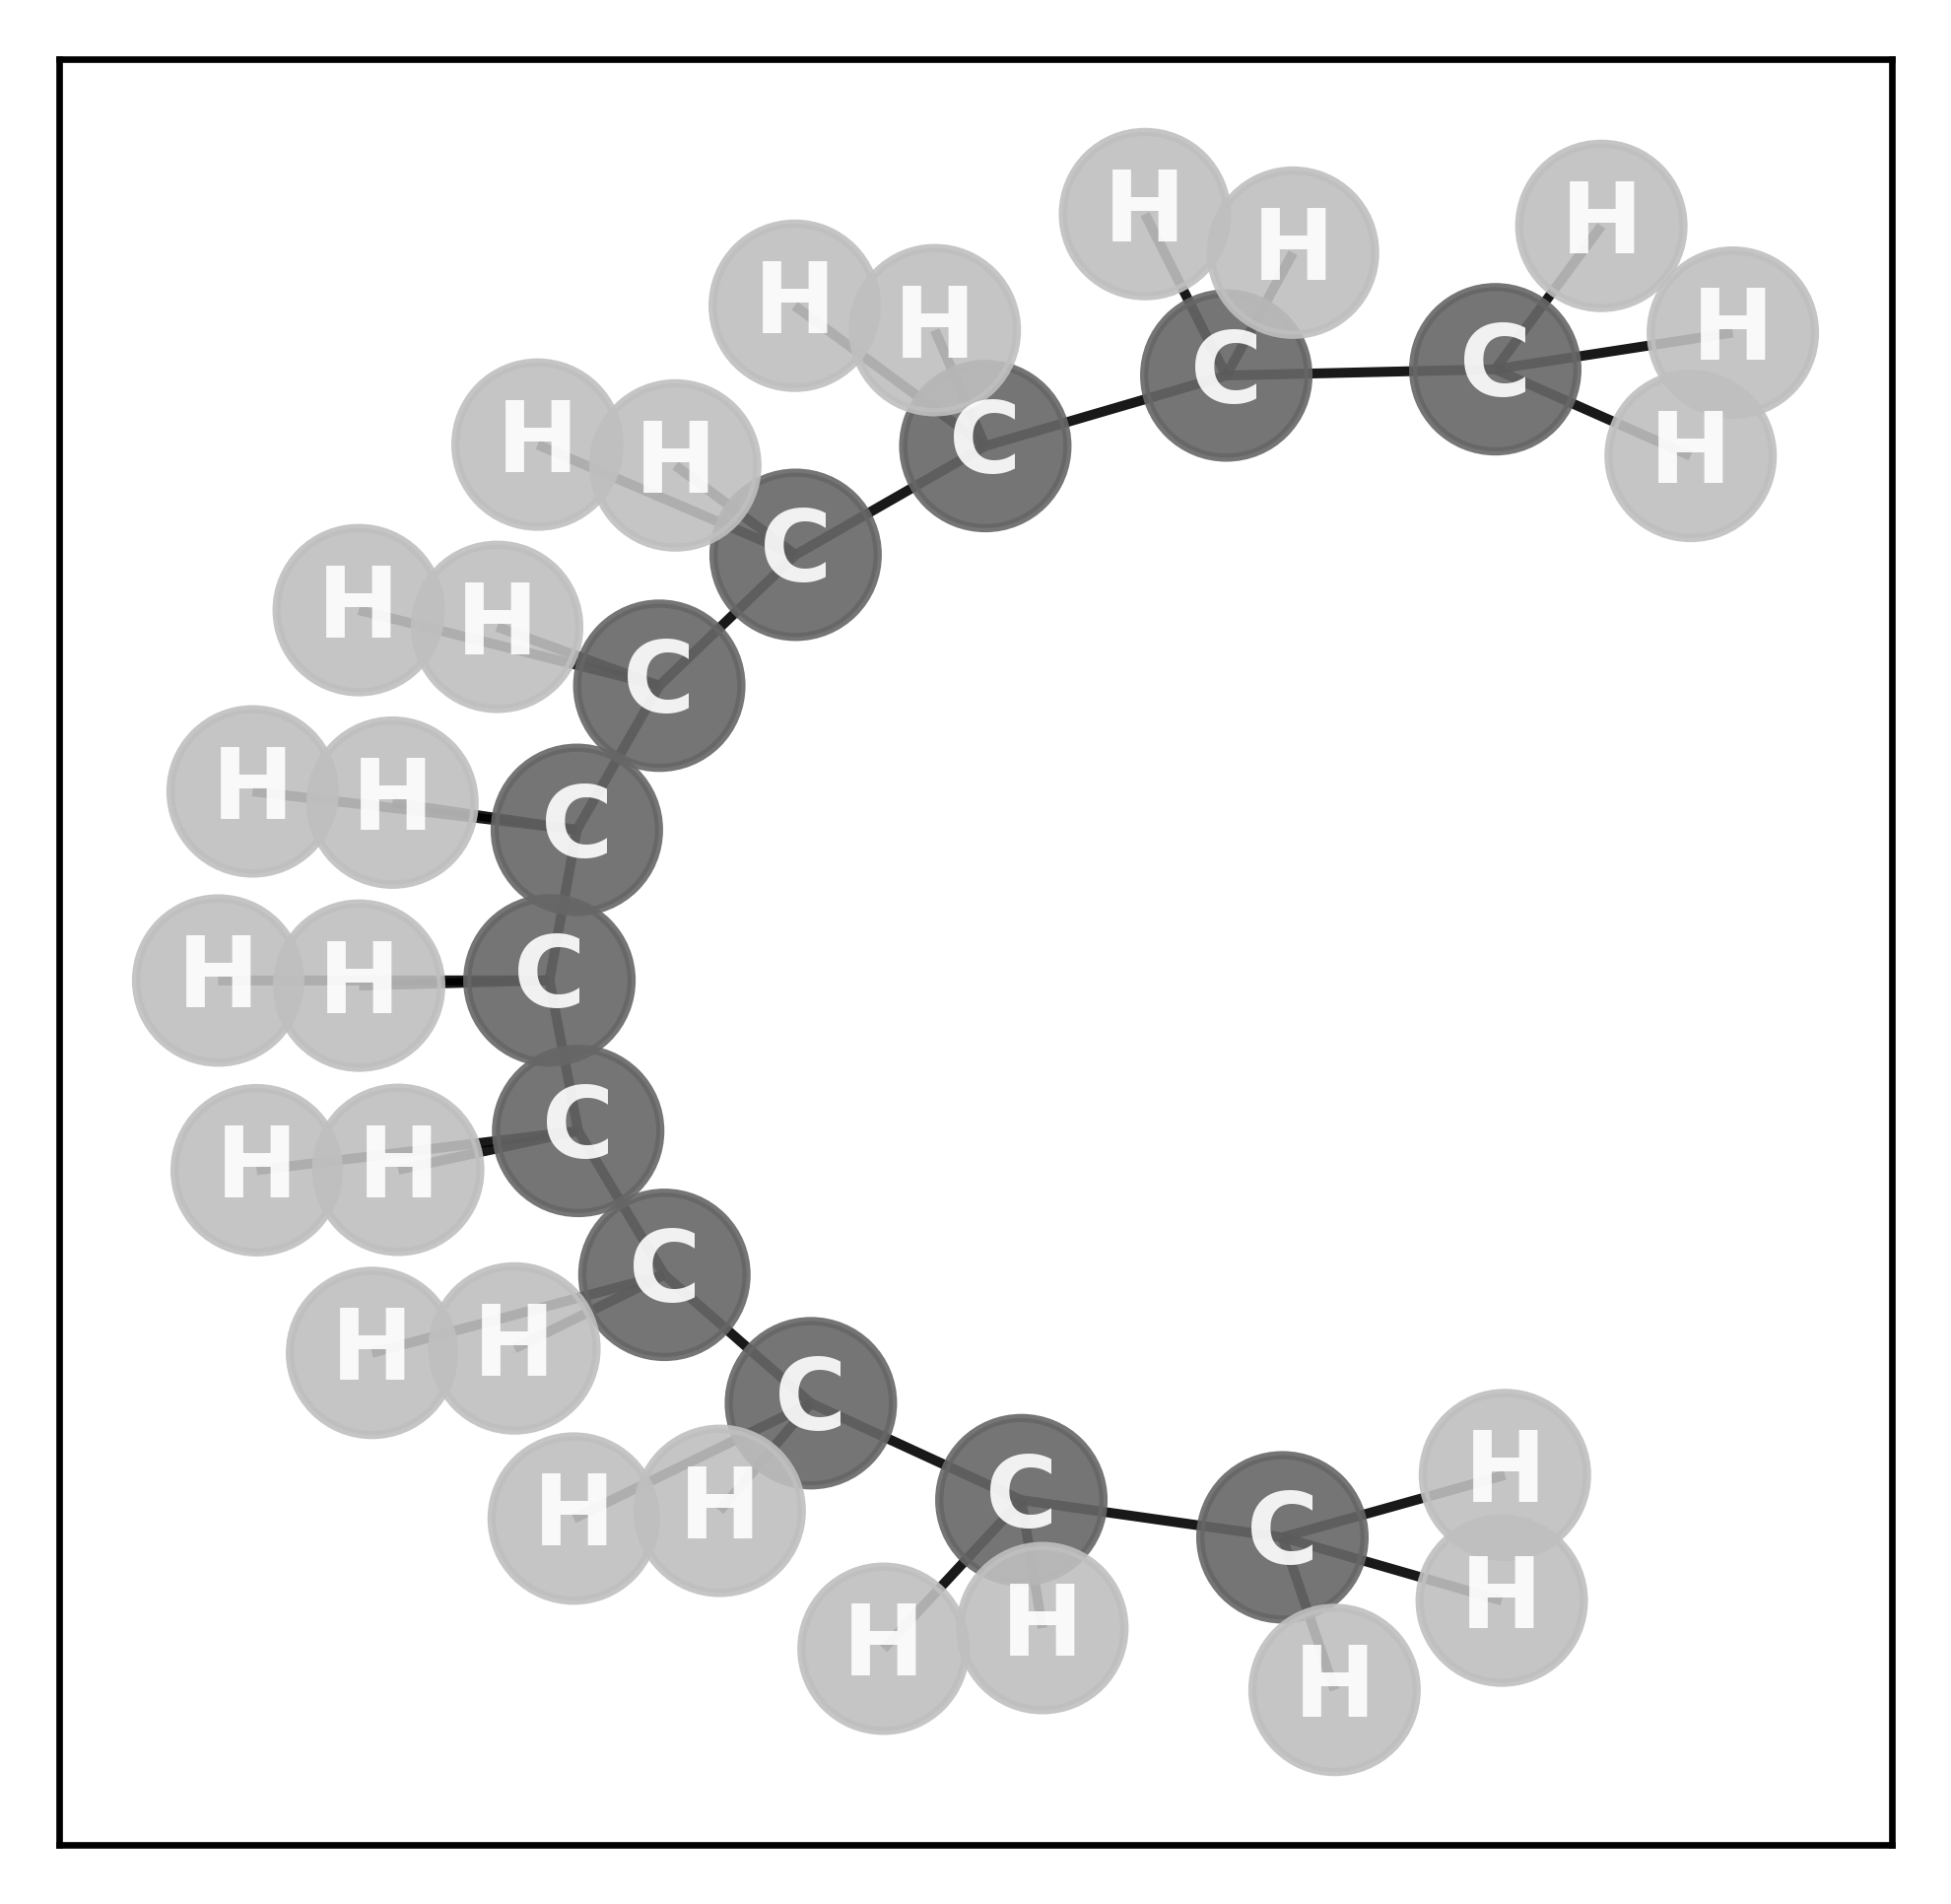

System: PE
GNN energy = -0.10 eV 
VASP energy = -206.62 eV
Prediction error = -206.52 eV
-----------------------------------


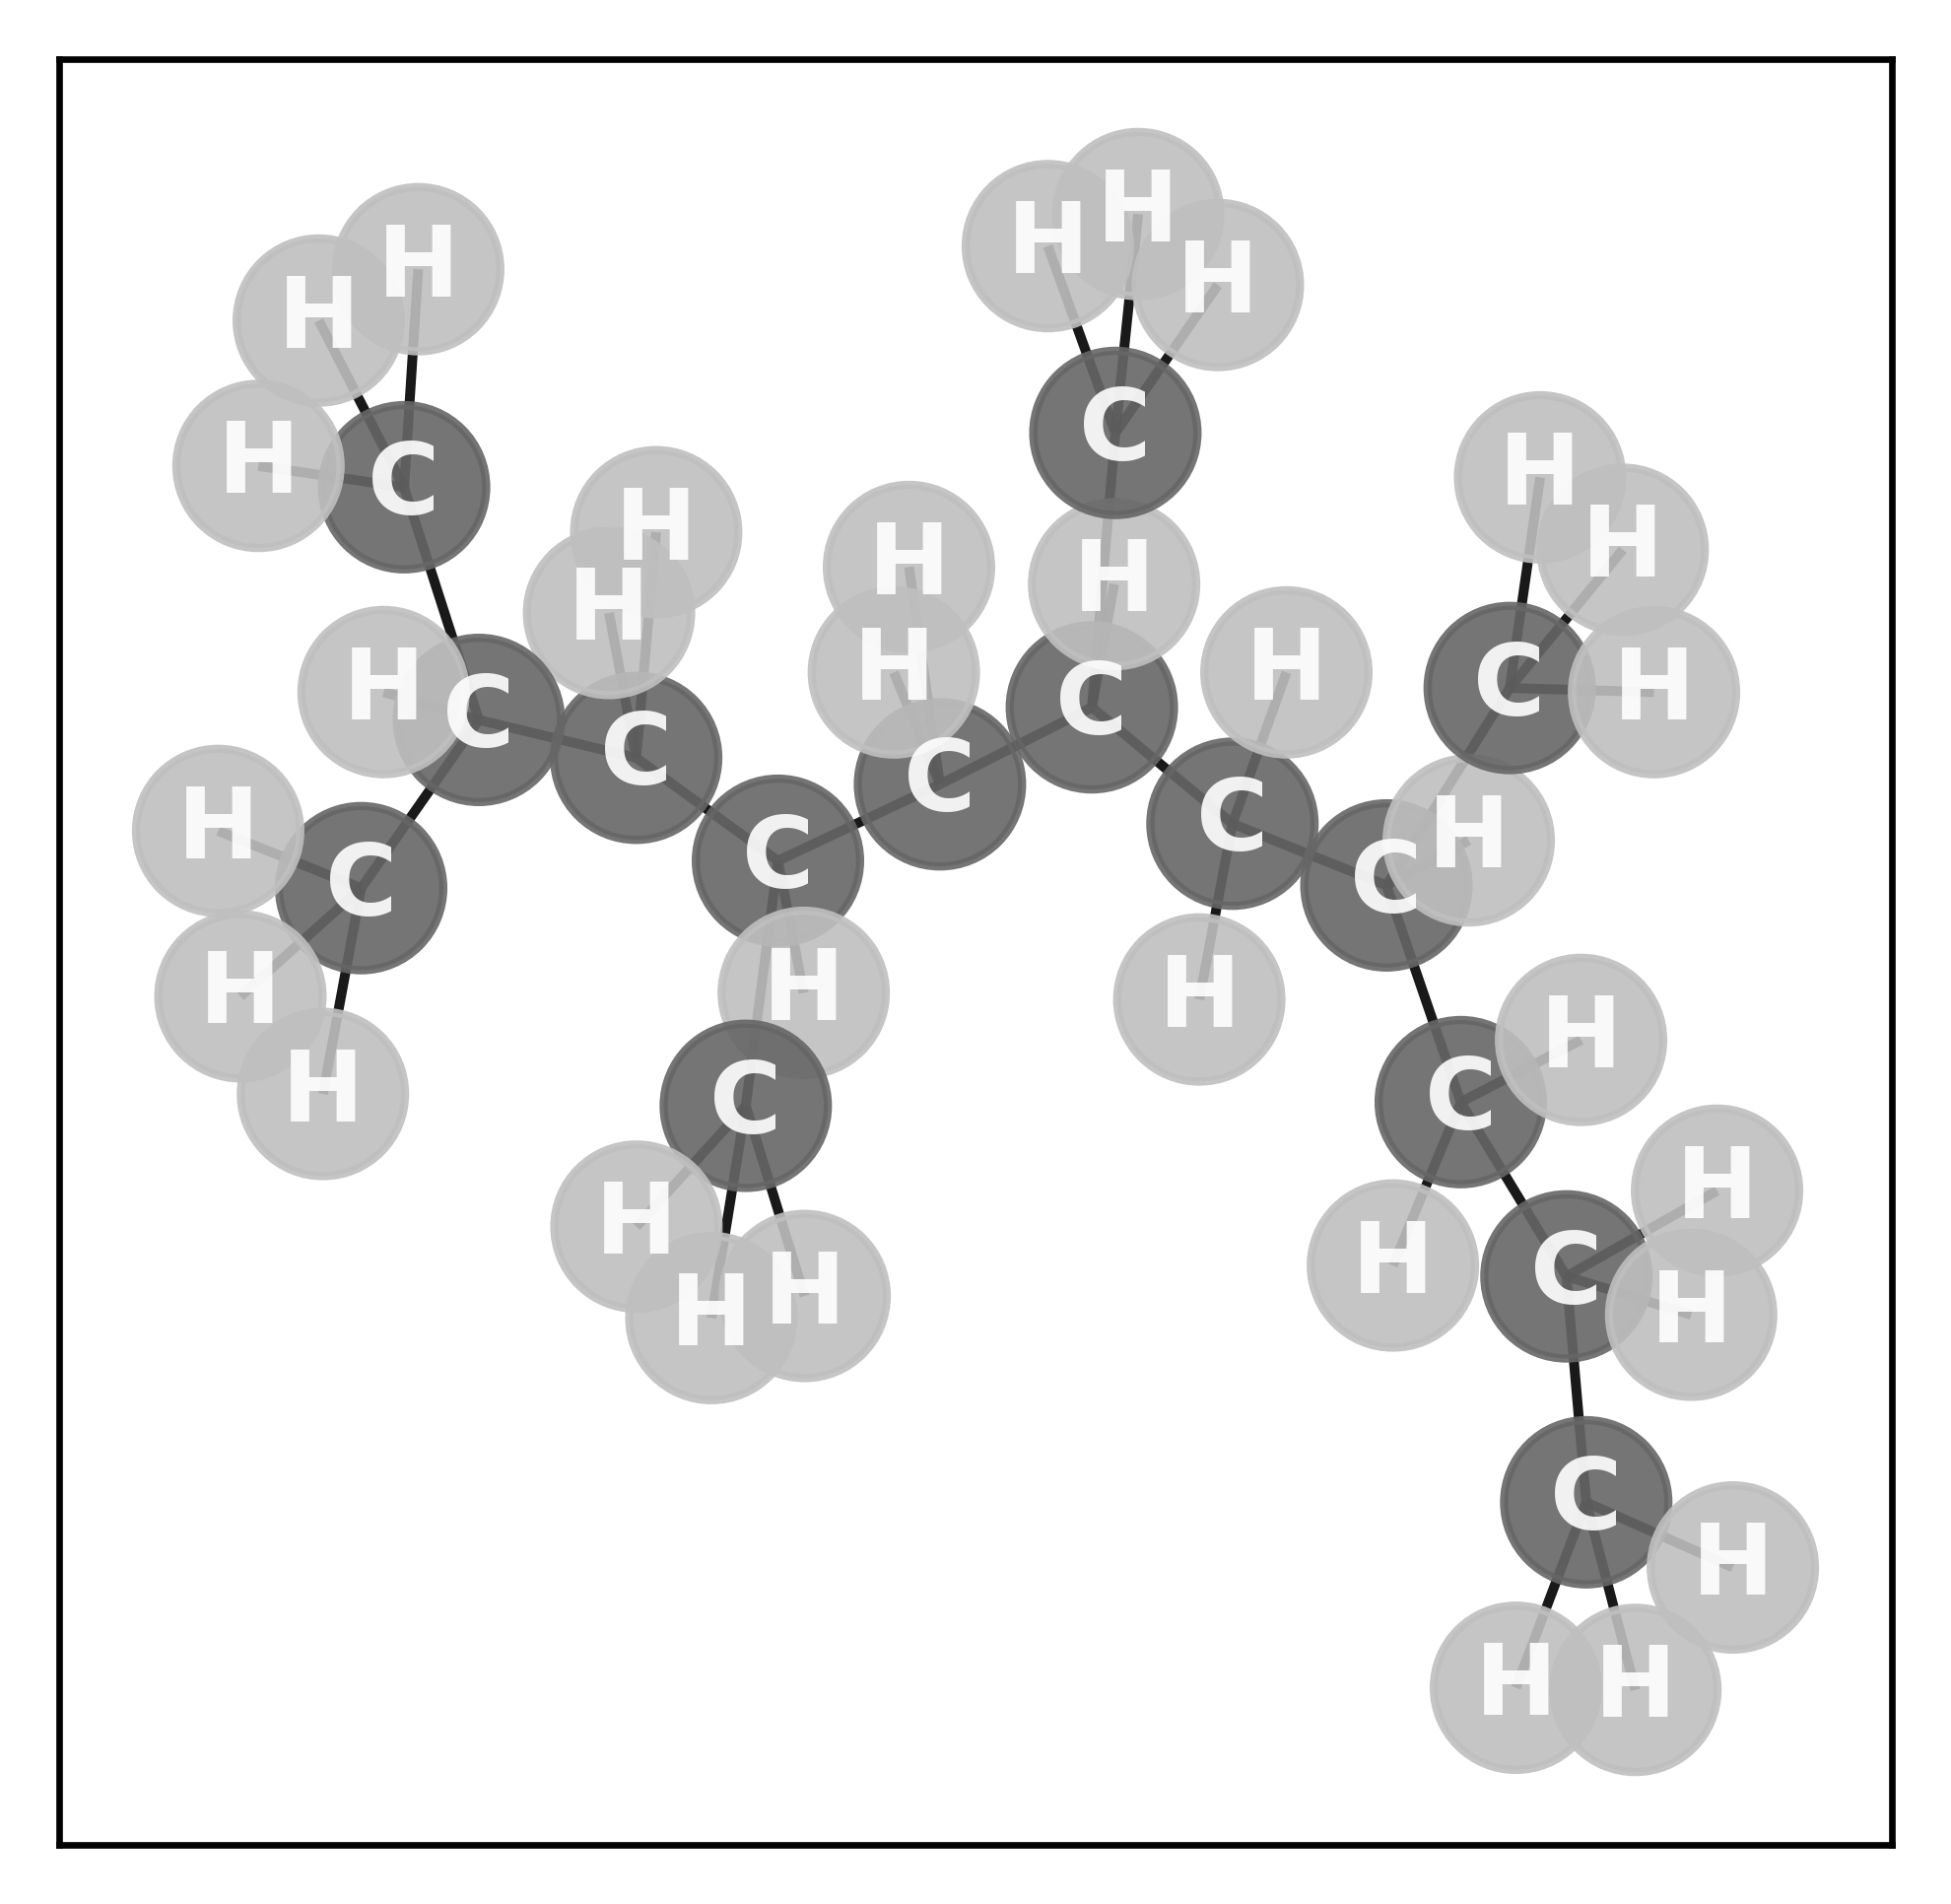

System: PPit
GNN energy = -0.09 eV 
VASP energy = -256.25 eV
Prediction error = -256.16 eV
-----------------------------------


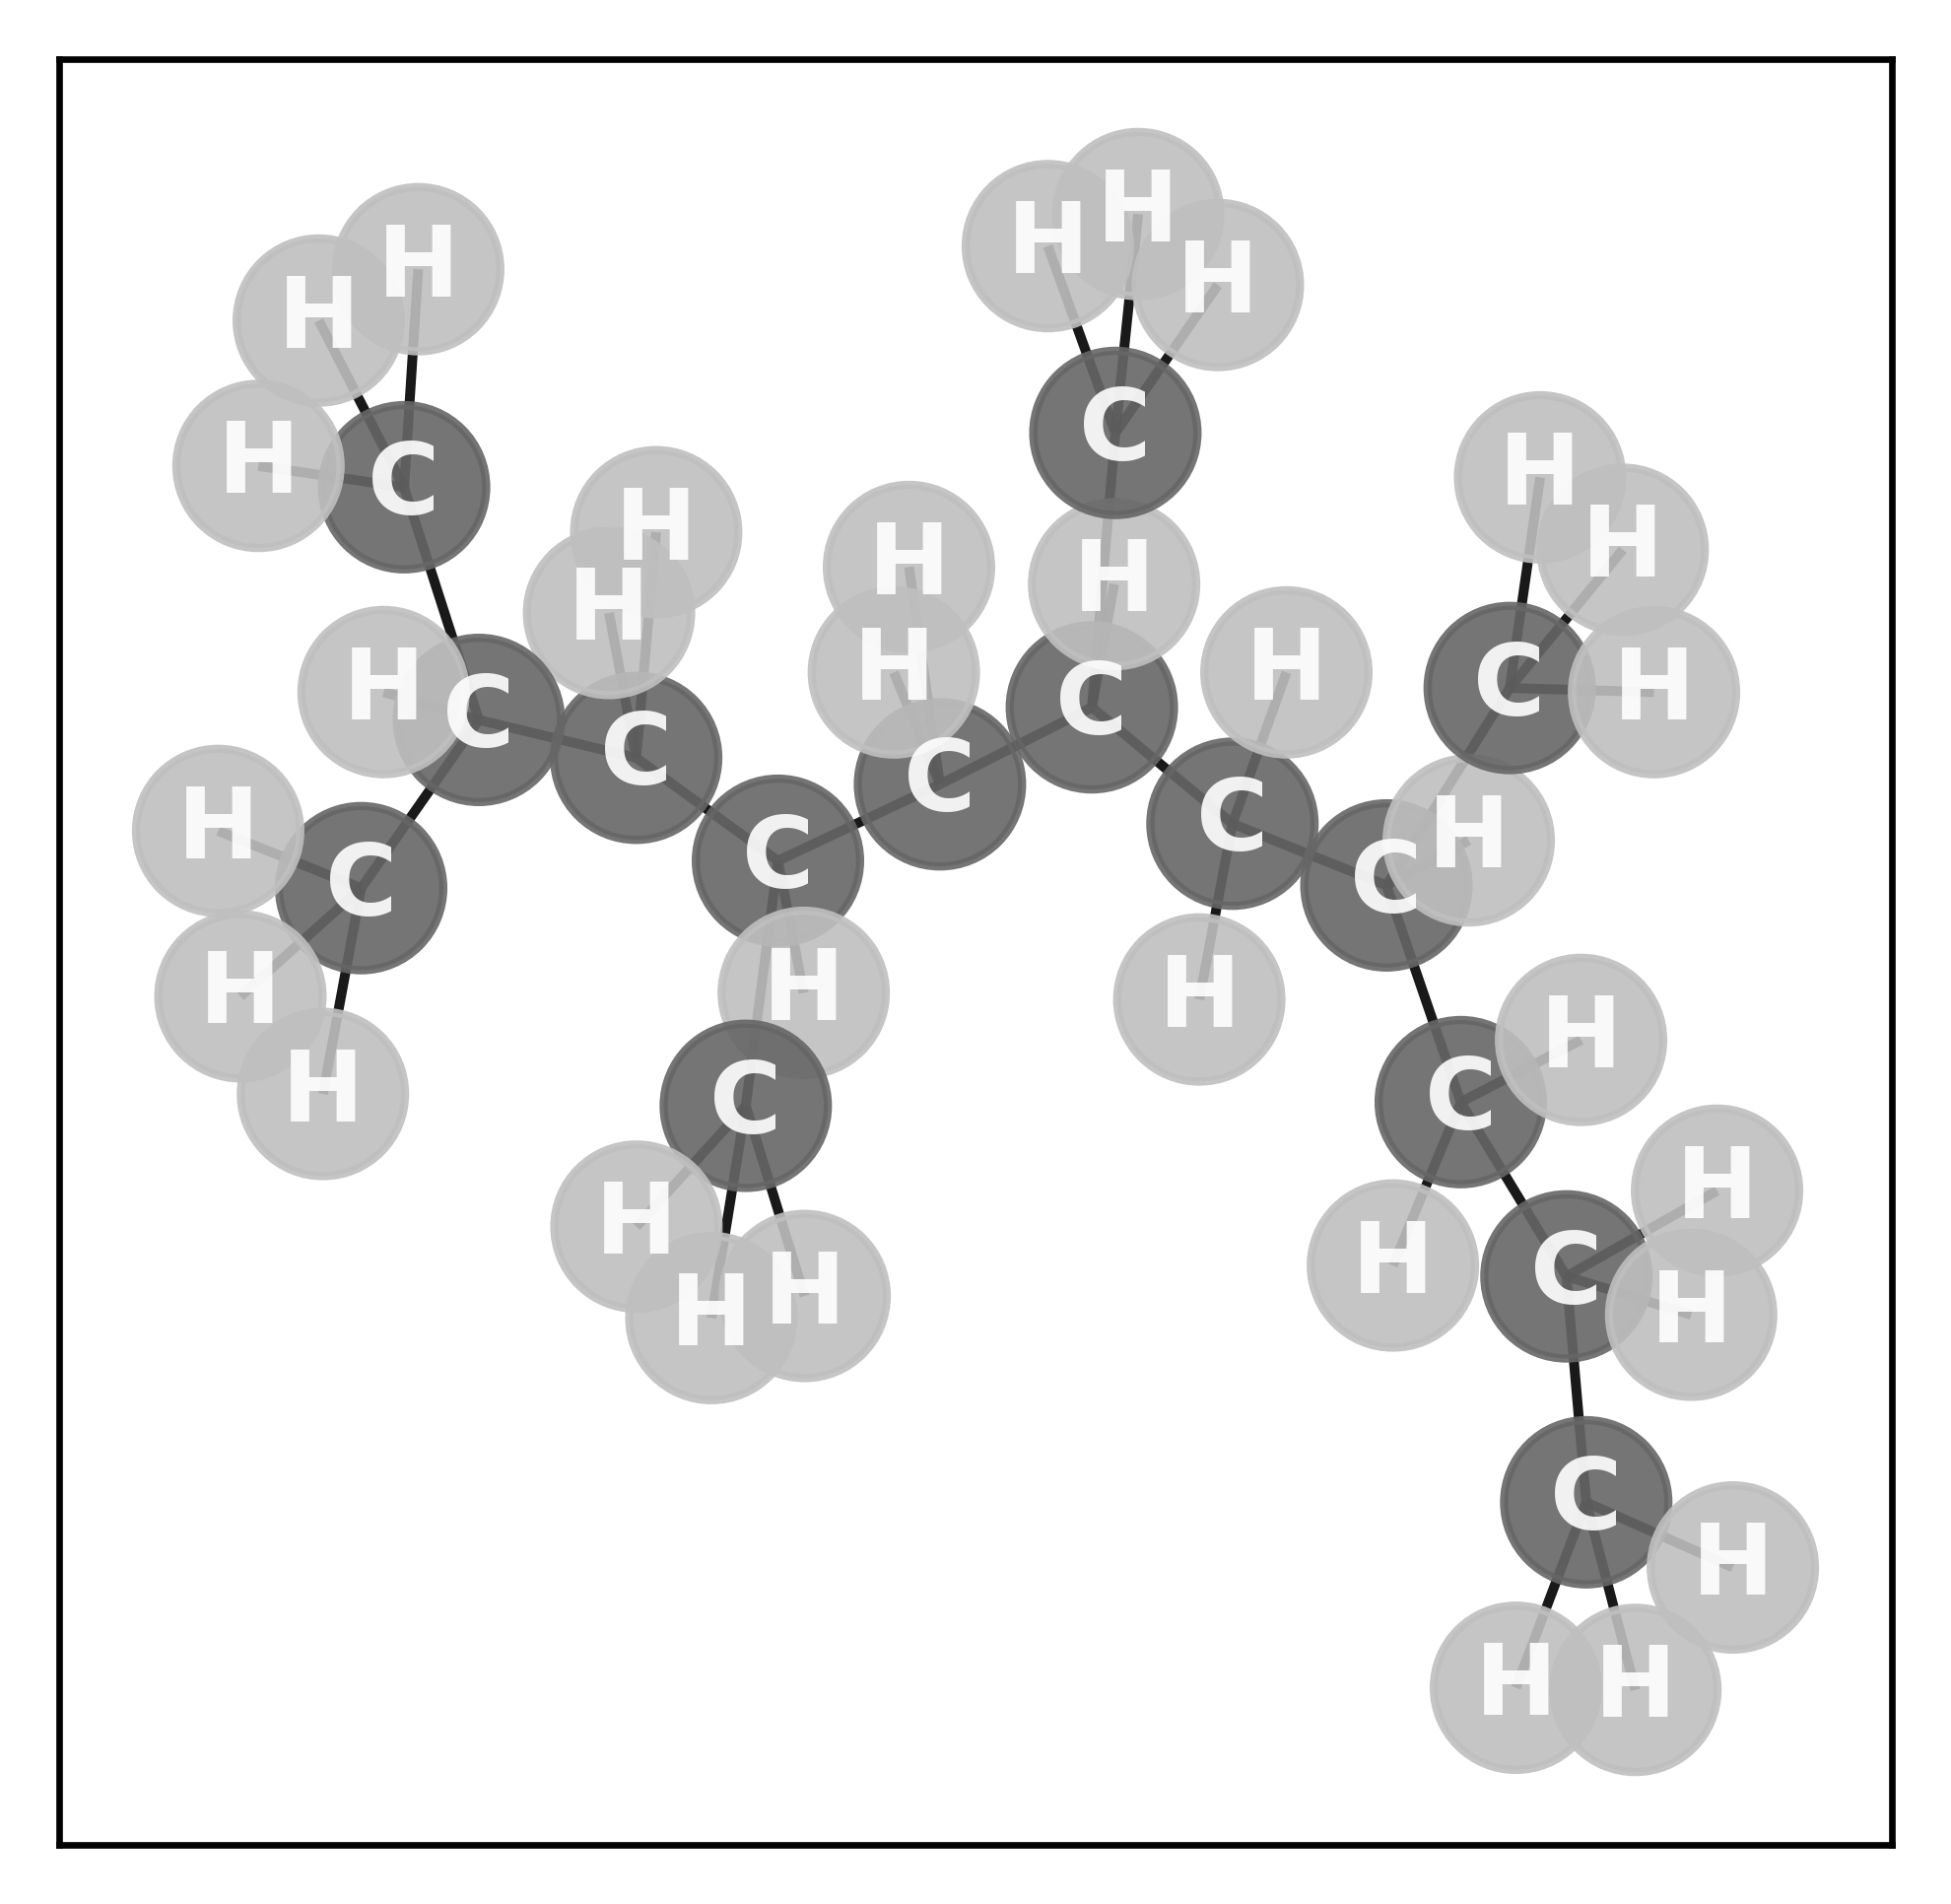

System: PPst
GNN energy = -0.09 eV 
VASP energy = -256.61 eV
Prediction error = -256.52 eV
-----------------------------------


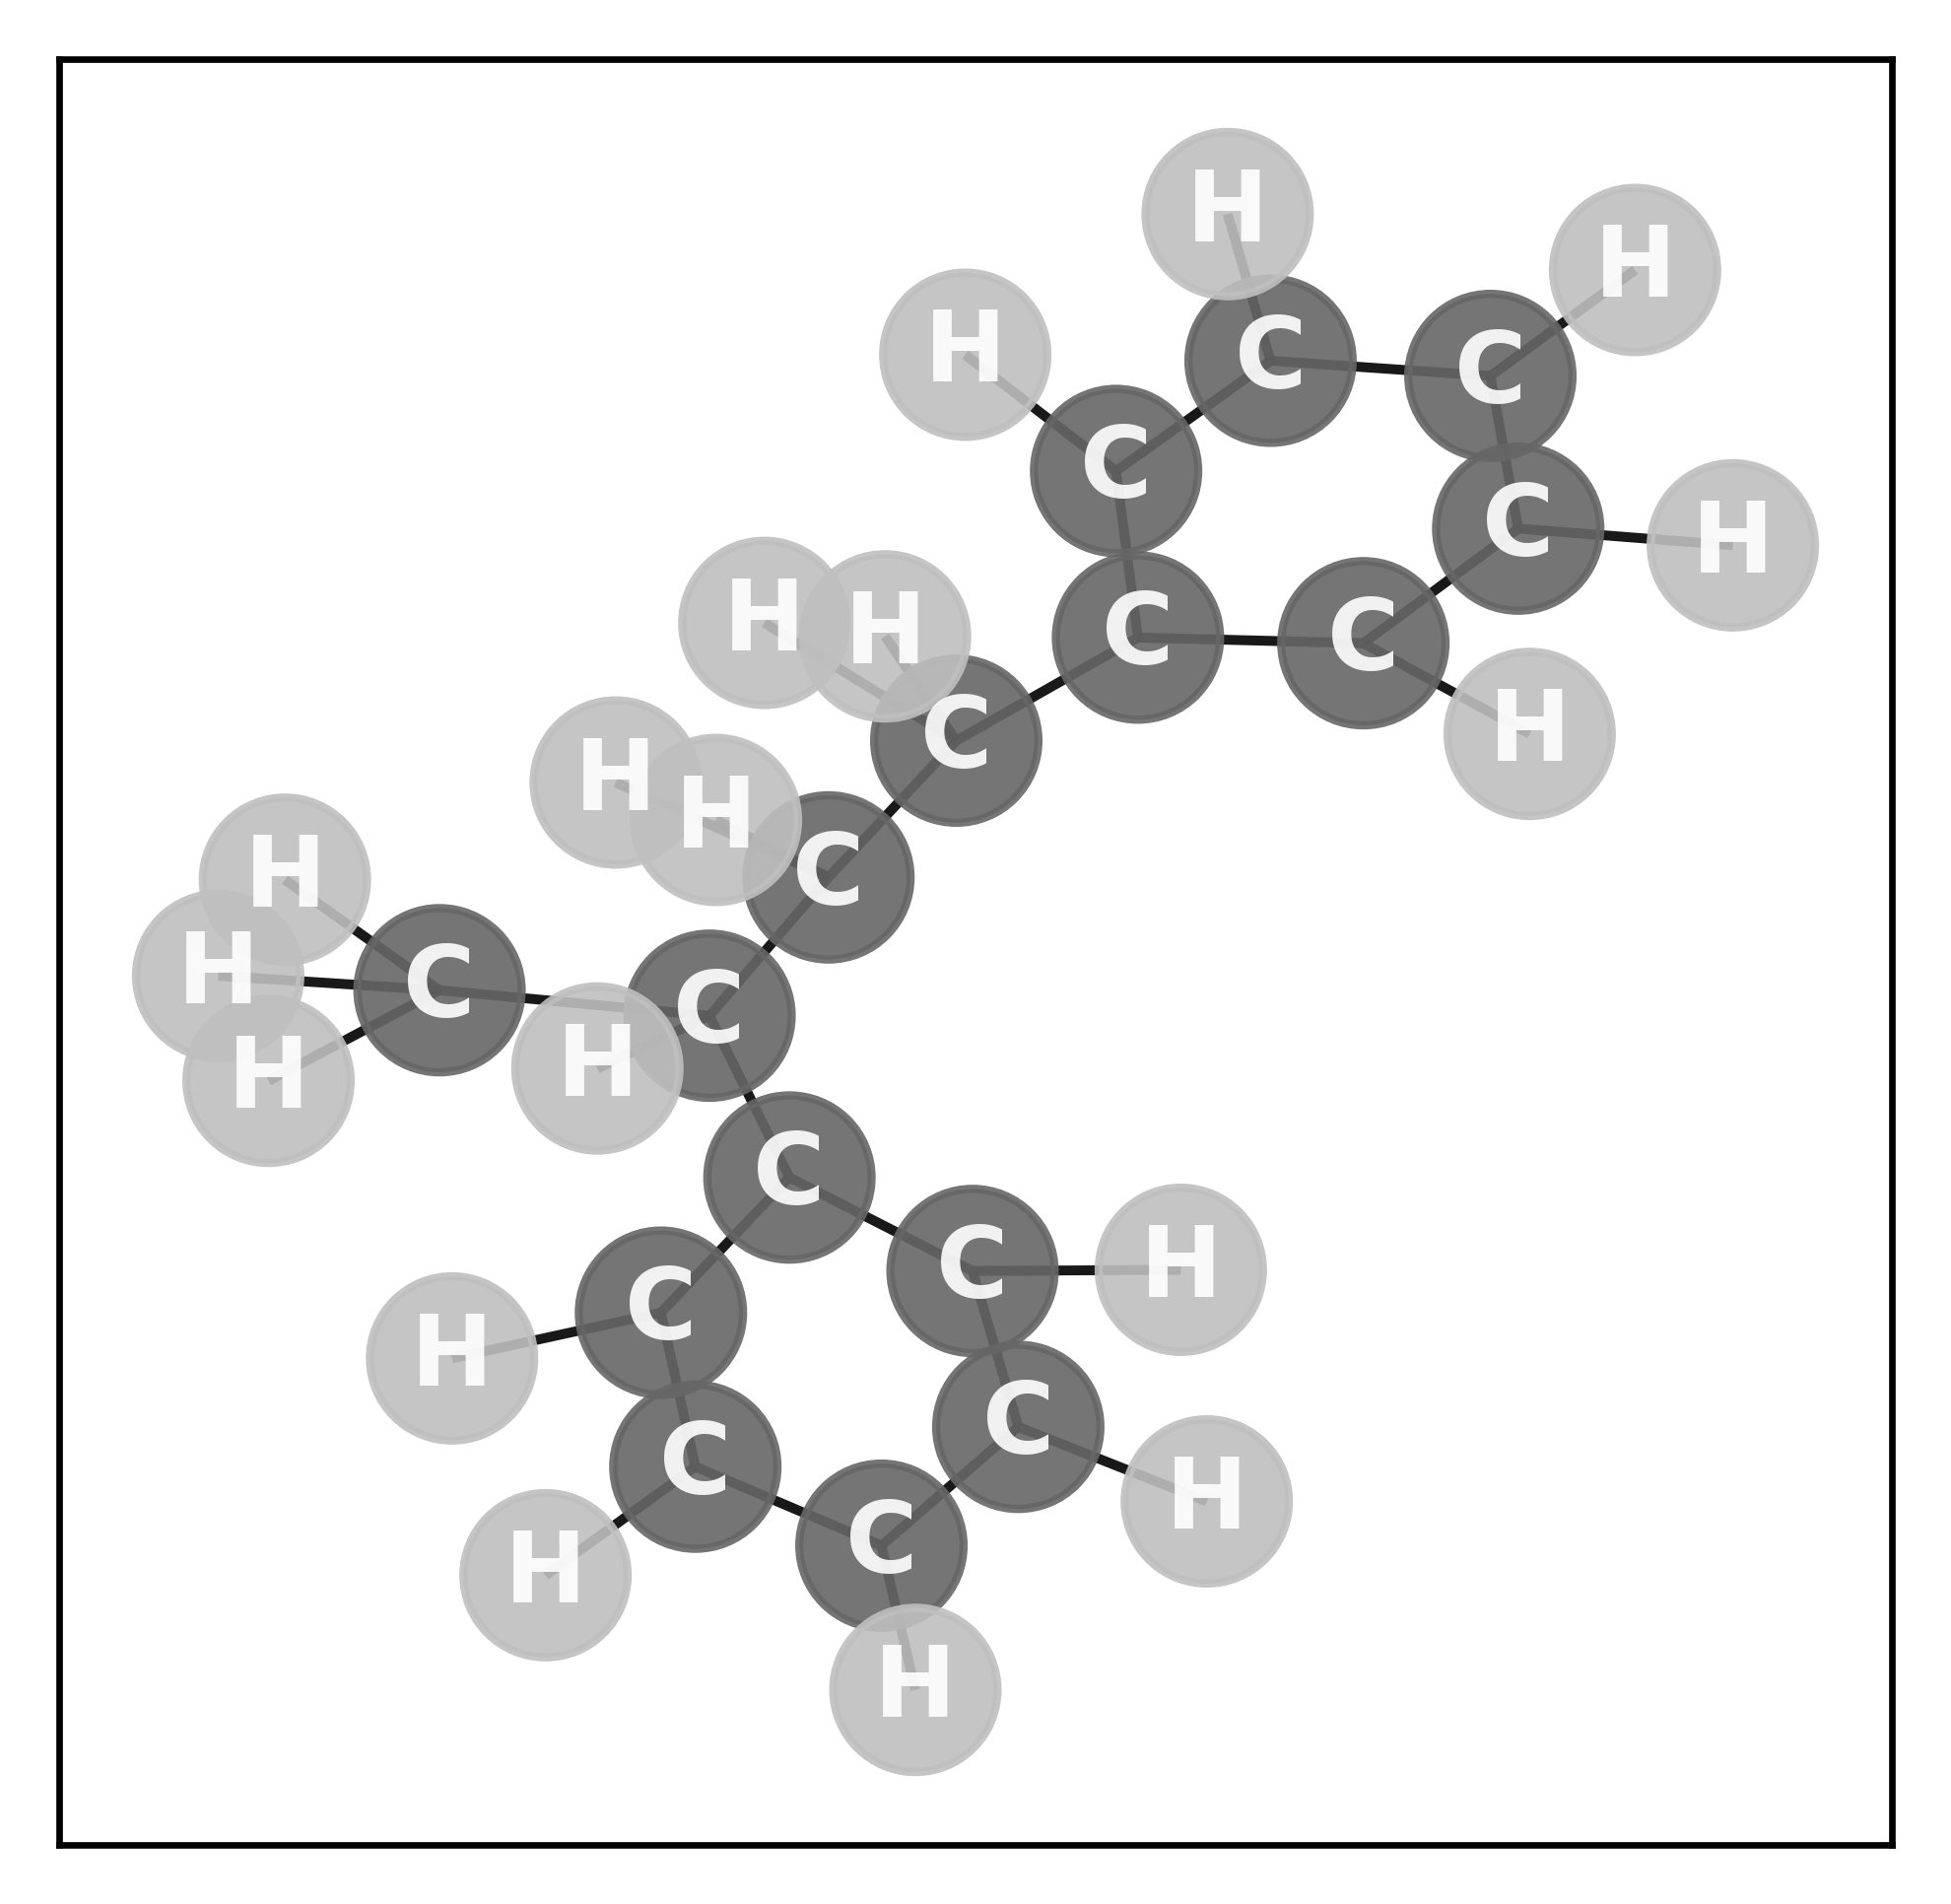

System: PS
GNN energy = -0.06 eV 
VASP energy = -211.60 eV
Prediction error = -211.54 eV
-----------------------------------


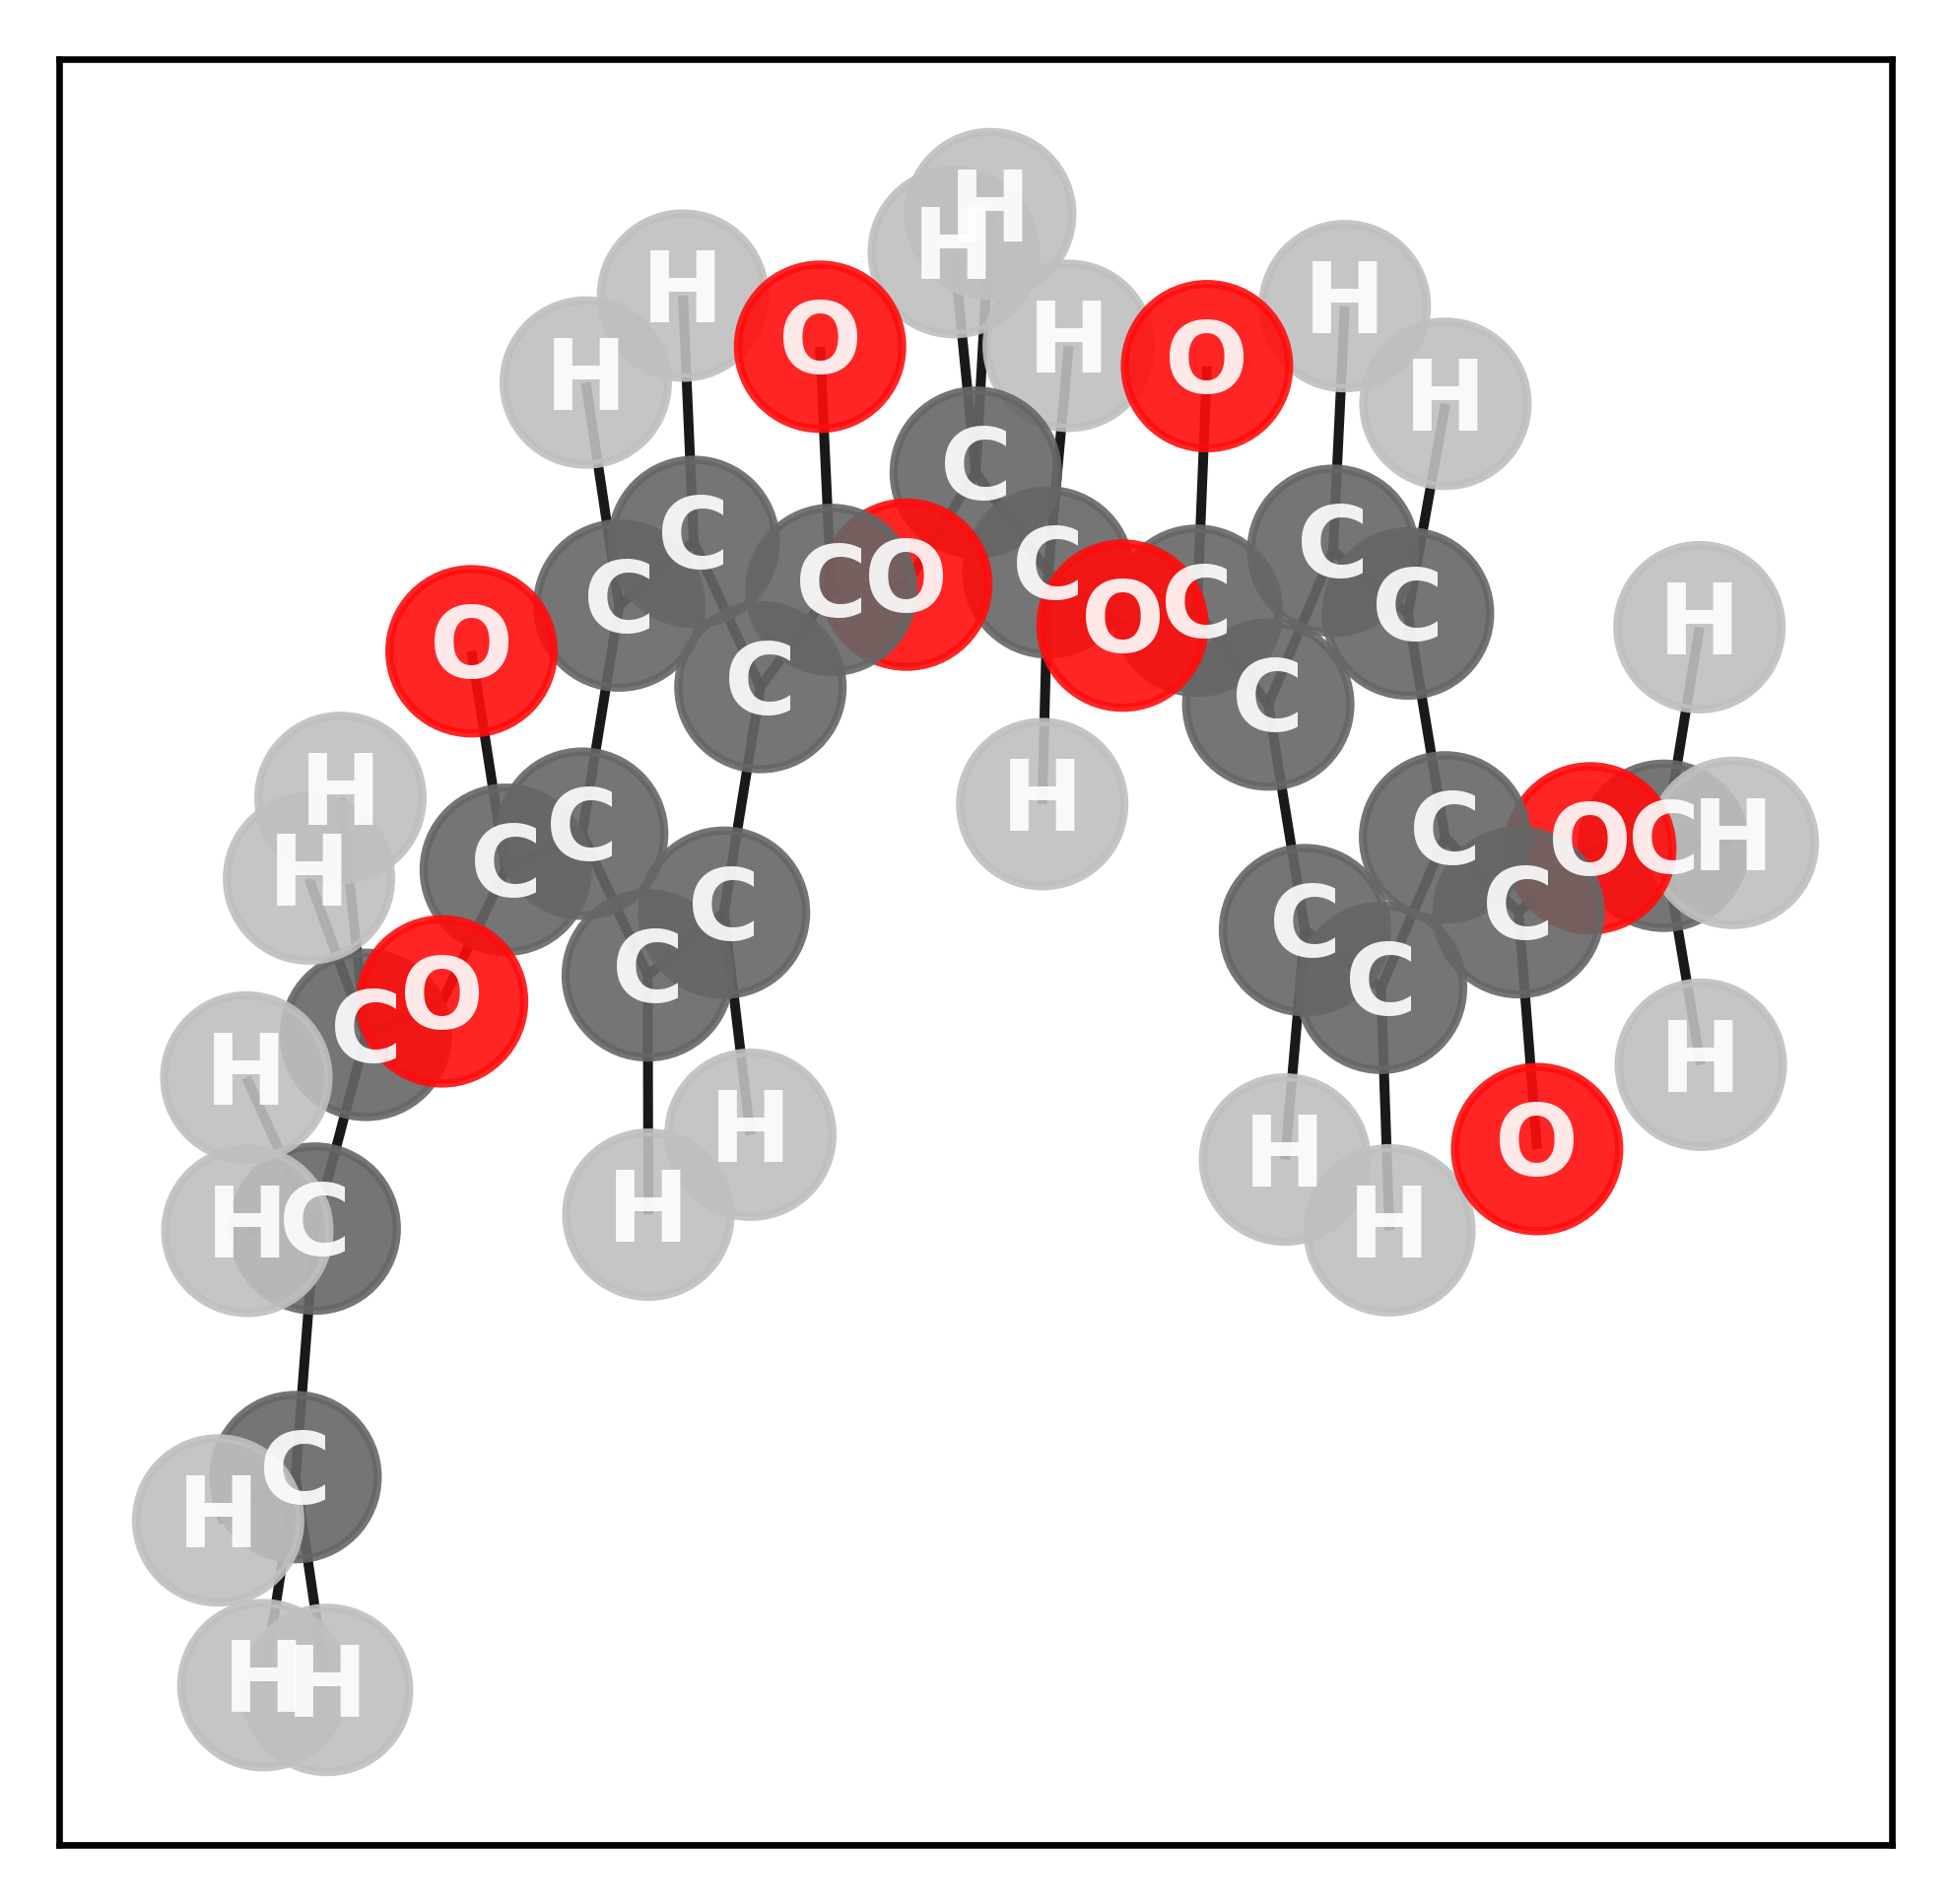

System: PET
GNN energy = -0.10 eV 
VASP energy = -334.82 eV
Prediction error = -334.71 eV
----------PLASTICS----------------
MAE = 253.61 eV
MAE/atom = 5.51 eV/atom
----------------------------------


In [1]:
from pymatgen.io.vasp import Outcar
from pyRDTP.geomio import file_to_mol
from functions import *
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch
from graph_tools import plotter
import matplotlib.pyplot as plt
from classes import *
from nets import *

""" MODEL_NAME = "SN1"
MODEL_PATH = "./Models/{}/".format(MODEL_NAME) """

MODEL_NAME = "5-20"
MODEL_PATH = "./{}/".format(MODEL_NAME)

pt_energy = Outcar("./Extrapolation/Plastics/pt-0000/OUTCAR").final_energy * 4
ru_energy = Outcar("./Extrapolation/Plastics/ru-0000/OUTCAR").final_energy * 4
sur = ["pt", "ru"]
plastic = ["PE", "PPit", "PPst", "PS", "PET"]
sur_energy = {"pt": pt_energy, "ru": ru_energy}
file = open("{}performance.txt".format(MODEL_PATH))
lines = file.readlines()
mean_tv = float(lines[3].split()[-2])
std_tv = float(lines[4].split()[-2])
model = SantyxNet(dim=128, node_features=node_features)
model.load_state_dict(torch.load("{}GNN.pth".format(MODEL_PATH)))
model.eval()
error = np.zeros((len(plastic)*(1 + len(sur)),1))
error_per_atom = np.zeros((len(plastic)*(1 + len(sur)),1))
abs_error = np.zeros((len(plastic)*(1 + len(sur)),1))
counter = 0
for metal in sur:
    for molecule in plastic:
        calc = "{}-{}".format(metal, molecule)
        system = "./Extrapolation/Plastics/{}/CONTCAR".format(calc)
        s = Outcar("./Extrapolation/Plastics/{}/OUTCAR".format(calc))
        s = s.final_energy
        mol = file_to_mol(system, 'contcar', bulk=False)
        mol = mol_to_ensemble(mol, VORONOI_TOLERANCE, CORDERO)
        nx_graph = ensemble_to_graph(mol)
        elem = list(nx_graph[1][0])
        source = list(nx_graph[1][1][0])
        target = list(nx_graph[1][1][1])
        elem_array = np.array(elem).reshape(-1, 1)
        elem_enc = encoder.transform(elem_array).toarray()
        edge_index = torch.tensor([source, target], dtype=torch.long)
        x = torch.tensor(elem_enc, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index)
        DL = DataLoader([data], batch_size=1, shuffle=False)   
        for batch in DL:
            energy = model(batch).item() * std_tv + mean_tv
        print("-----------------------------------")
        #plotter(data)
        plt.show()
        print("System: {}-{}".format(metal, molecule))
        print("GNN energy = {:.2f} eV ".format(energy))
        print("VASP energy = {:.2f} eV".format(s - sur_energy[metal]))
        print("Prediction error = {:.2f} eV".format(s - sur_energy[metal] - energy))
        error[counter] = s - sur_energy[metal] - energy
        abs_error[counter] = abs(error[counter])
        error_per_atom[counter] = abs_error[counter] / data.num_nodes
        counter += 1
for molecule in plastic:  # gas phase molecules
    calc = "{}".format(molecule)
    system = "./Extrapolation/Plastics/{}/CONTCAR".format(calc)
    s = Outcar("./Extrapolation/Plastics/{}/OUTCAR".format(calc))
    s = s.final_energy
    mol = file_to_mol(system, 'contcar', bulk=False)
    mol = mol_to_ensemble(mol, VORONOI_TOLERANCE, CORDERO)
    nx_graph = ensemble_to_graph(mol)
    elem = list(nx_graph[1][0])
    source = list(nx_graph[1][1][0])
    target = list(nx_graph[1][1][1])
    elem_array = np.array(elem).reshape(-1, 1)
    elem_enc = encoder.transform(elem_array).toarray()
    edge_index = torch.tensor([source, target], dtype=torch.long)
    x = torch.tensor(elem_enc, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    DL = DataLoader([data], batch_size=1, shuffle=False)   
    for batch in DL:
        energy = model(batch).item() * std_tv + mean_tv
    print("-----------------------------------")
    plotter(data)
    plt.show()
    print("System: {}".format(molecule))
    print("GNN energy = {:.2f} eV ".format(energy))
    print("VASP energy = {:.2f} eV".format(s))
    print("Prediction error = {:.2f} eV".format(s- energy))
    error[counter] = s - energy
    abs_error[counter] = abs(error[counter])
    error_per_atom[counter] = abs_error[counter] / data.num_nodes
    counter += 1
print("----------PLASTICS----------------")
print("MAE = {:.2f} eV".format(np.mean(abs_error)))
print("MAE/atom = {:.2f} eV/atom".format(np.mean(error_per_atom)))
print("----------------------------------")
        